In [3]:
import numpy as np 
import sympy as s 
import matplotlib.pyplot as plt

# Spring Calcs

### Parameters

In [4]:
f_op = 8000/60 /2 #rpm * min/sec = Hz, divided by 2 for the ratio Crank to Cam
travel_req = .010349 #m

### Formula Definitions

In [5]:
#Stiffness & Coils
d, G, D, Na, k = s.symbols("d G D N_a k")

stiffness = s.Eq(d**4 * G / (8 * D**3 * Na), k)

Nt, p, Ls, Lf = s.symbols('N_t p L_s L_f')

total_coil = s.Eq(Na + 2, Nt)
length_solid = s.Eq( (Nt - .75)*d, Ls)
length_free = s.Eq( p*Na + 2*d, Lf )
pitch = s.Eq( (Lf - 2*d)/Na , p)

ID = s.symbols("D_i")
ID = s.Eq( D - d, ID)

In [6]:
# Stability
E, alp, L0 = s.symbols('E \alpha L_0')

stable_length = s.Eq(np.pi * D / alp * (2 * (E - G)/(2*G + E))**.5, L0)

In [7]:
# Resonance
g, W, dens, f = s.symbols("g W \roh f")
grav = 9.81 #m/s/s/
weight = s.Eq(np.pi**2 * d**2 * D * Na/4 * dens, W)
freq = s.Eq( 1/2 * (k * g / W)**.5, f)

# Analysis

In [18]:
# Materials
G_ASTM401 = 77.2E9 #Pa
E_ASTM401 = 203.4E9 #Pa

Basic Spring Dimensions

In [19]:
G_choose = G_ASTM401
E_choose = E_ASTM401

D_choose = .020625 #m
d_choose = .003048 #m
Na_choose = 7 #coil #
Lf_choose = .04450 #m
density = 7750 #kg/m3

Stiffness Calculation


In [20]:
k_eval = s.solve(stiffness.subs([(d, d_choose),(G,G_choose),(D, D_choose),(Na, Na_choose)]), k)[0]
print("Stiffness Evaluated to: " + str(k_eval) + "N/m")

Stiffness Evaluated to: 13561.4851372780N/m


In [21]:
Nt_eval = s.solve(total_coil.subs([(Na,Na_choose)]), Nt)[0]
Ls_eval = s.solve(length_solid.subs([(Nt, Nt_eval),(d, d_choose)]), Ls)[0]
p_eval = s.solve(pitch.subs([(Na, Na_choose),(d, d_choose),(Lf, Lf_choose)]))[0]
c = D_choose / d_choose 

print("N_total: " + str(Nt_eval))
print("N_active: " + str(Na_choose))
print("Pitch: " + str(p_eval))
print("Solid Length: " + str(Ls_eval))
print("Free Length: " + str(Lf_choose))
print("Index: " + str(c))

print("Sufficient Travel: " + str(Lf_choose - Ls_eval) + " > " + str(travel_req) + " :: " + str((Lf_choose - Ls_eval) > travel_req))

N_total: 9
N_active: 7
Pitch: 0.00548628571428571
Solid Length: 0.0251460000000000
Free Length: 0.0445
Index: 6.766732283464568
Sufficient Travel: 0.0193540000000000 > 0.010349 :: True


### Resonance

In [22]:
m_eval = s.solve(weight.subs([(d, d_choose),(D, D_choose),(Na, Na_choose),(dens, density)]), W)[0]
W_eval = m_eval * grav

f_eval = s.solve(freq.subs([(W, W_eval),(g, grav),(k, k_eval)]), f)[0] 

print("Weight = " + str(W_eval))
print("Natural Frequency = " + str(round(f_eval,3)) + " > " + str(round(f_op,3)) + " by " + str(round(f_eval/f_op, 1)) + "x")

Weight = 0.251612600604009
Natural Frequency = 363.573 > 66.667 by 5.5x


### Stability

In [23]:
alpha = 0.5 # for two flat plate end conditions, per Table 10-2 Shigleys
L0_eval = s.solve(stable_length.subs([(D, D_choose),(alp, alpha),(E, E_choose),(G, G_choose)]), L0)[0]

print("Minimum Stable Length = " + str(round(L0_eval, 4)) + "m" + " :: " + "Is greater than Ls: " + str(L0_eval > Ls_eval))

Minimum Stable Length = 0.1088m :: Is greater than Ls: True


### Fatigue

In [24]:
K_B =  (4 * c + 2) / (4 * c - 3) # Bergstrasser
print("K_B = " + str(K_B))

K_B = 1.2077539669556683


In [35]:
# Middle and Amplitude Values of Force Applied

L_pre = 44.1765E-3
L_app = L_pre - travel_req

F_pre = (Lf_choose - L_pre) * k_eval
F_app = (Lf_choose - L_app) * k_eval

F_amp = F_app / 2
tau_amp =  K_B * 8 * F_amp * D_choose / np.pi / d_choose**3
F_avg = (F_pre + F_app) - F_amp
tau_avg = tau_amp * F_avg / F_amp

print("tau_amp = " + str(tau_amp/(1E6)) + " MPa")
print("tau_avg = " +  str(tau_avg/(1E6)) + " MPa")

tau_amp = 162.110474246699 MPa
tau_avg = 171.938113210167 MPa


In [26]:
A = 1974 # Table 10-4, MPa
m = .108 # Table 10-4
Sut = A/( (d_choose*1000) ** m) # divided to be in units of mm
print("Ult Tensile = " + str(Sut))

Sus = 2/3 * Sut #MPa
Sys = .56 * Sut #MPa

Sas = 241 # Formula 10-28, MPa
Sms = 379 # Formula 10-29, MPa
Ses = Sas / (1 - (Sms / Sus)**2)

print("Shear Ultimate = " + str(Sus))
print("Shear Endurance = " + str(Ses))


Ult Tensile = 1750.142988175243
Shear Ultimate = 1166.7619921168287
Shear Endurance = 269.42875330612185


In [27]:
y, xSus, xSm, ySe, ySa, x = s.symbols("y x_{Sus} x_{Sm} y_{Se} y_{Sa} x")
Goodman = s.Eq(ySe - ySe/xSus * x, y)
LL = s.Eq(ySa / xSm * x, y)
solns = s.solve([Goodman, LL], (x,y))
fatigue_strength = solns[x].subs([(xSus, Sus),(ySe, Ses),(xSm, tau_avg/(1E6)),(ySa, tau_amp/(1E6))]) # converted Pa to MPa
FoS = fatigue_strength/(tau_avg/(1E6))
print("Middle Value Endurance Strength = " + str(fatigue_strength))
print("FoS = " + str(FoS))

Middle Value Endurance Strength = 229.542904878507
FoS = 1.33503212634378


Text(0, 0.5, 'Amplitude/Endurance Stress, MPa')

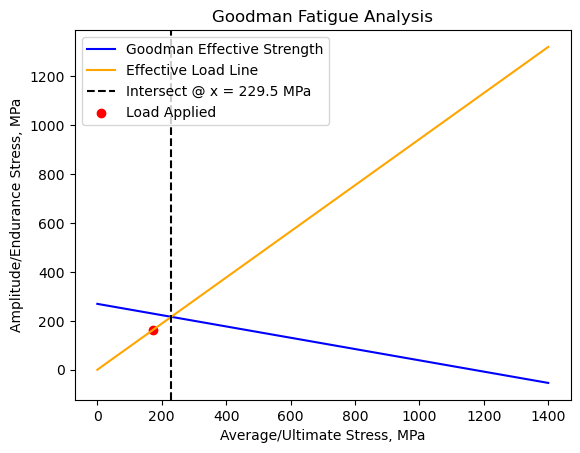

In [44]:
# Plotted Goodman:
xrange = np.linspace(0, Sus*1.2, 200)
points_Goodman = Ses - Ses/Sus * xrange 
points_Loadline = tau_amp / tau_avg * xrange

plt.plot(xrange, points_Goodman, color = 'blue', label = "Goodman Effective Strength")
plt.plot(xrange, points_Loadline, color = 'orange', label = "Effective Load Line")
plt.axvline(fatigue_strength, color = 'black', linestyle = "--", label = ("Intersect @ x = " + str(round(fatigue_strength,1)) + " MPa"))
plt.scatter(x = tau_avg/1E6, y = tau_amp/1E6, color = 'red', label = "Load Applied")
plt.legend()
plt.title("Goodman Fatigue Analysis")
plt.xlabel("Average/Ultimate Stress, MPa")
plt.ylabel("Amplitude/Endurance Stress, MPa")